# Paper Implementation: An Improved Collaborative Filtering Recommendation Algorithm and Recommendation Strategy

This project is based on the paper “An Improved Collaborative Filtering Recommendation Algorithm and Recommendation Strategy” by Xiaofeng Li and Dong Li. All research rights and intellectual property belong to the original authors under the Creative Commons Attribution License. We (Matteo and Julian, students at the University of Bolzano) have chosen this work as the foundation for a full analysis and software implementation of its proposed methods, to both validate and extend its contributions to community‑aware collaborative filtering.

## 1. Introduction

Li & Li (2019) address key limitations of traditional collaborative filtering (CF) data sparsity, cold start, and scalability by integrating overlapping community detection into the CF pipeline. They propose two algorithms to mine user communities from a social network projection of user–item interactions (central‑node‐based and k‑faction). By localizing neighbor selection within these communities and combining rating‐based similarity with category‐based similarity, they demonstrate significant reductions in MAE and RMSE on MovieLens‑100K.

## 2. Implementation Roadmap

Below is our high‑level plan to reproduce and extend Li & Li’s community‑aware CF framework:

---
1. **Dataset Preparation**
    - Download and preprocess the MovieLens 100K dataset.
    - Build the user–item rating matrix.
    - Build the User–Genre Preference Matrix
---
2. **Community Detection**
   1. **Central‑Node Algorithm**
      - Compute node degrees; seed each community with the highest‑degree node.
      - Iteratively add neighbors that maximize the local contribution $(q)$.
      - Merge any two communities whose overlap $(S \ge 0.7)$.
   2. **k‑Faction Algorithm**
      - Use Bron–Kerbosch to extract all cliques of $size ≥ k$.
      - Merge cliques based on an overlap threshold $(T)$ and inter‑community connectivity.
      - Assign remaining nodes to their closest community; refine by maximizing modularity $(Q_c)$.
---
3. **Community‑Based Collaborative Filtering**
    - For each target user, restrict neighbor search to their detected community.
    - Construct a user–category binary matrix.
    - Compute hybrid similarity:
    $$
    \mathrm{sim}(u, v) \;=\;(1 - \lambda)\,\mathrm{sim}_R(u, v)\;+\;\lambda\,\mathrm{sim}_{\mathrm{cate}}(u, v).
    $$
    - Predict ratings by aggregating the top‑*K* most similar users’ ratings.
---
4. **Train Framework**
    - Perform 5‑fold cross‑validation with varying training test split and k:.
    - **Experiment1:** Fix $K$; vary train and test ratio → assess sparsity impact.
    - **Experiment2:** Fix a training and test ration and vary $K$ → find optimal neighbor set size.
    - Measure MAE, RMSE Precision and Recall for:
        - **CFCD** (Community‑based CF)
        - **CFC** (Cosine CF)
        - **CFP** (Pearson CF)
---
5. **Evaluate Results**
   - Analyze Train Test Split and K differences.
   - Plot and elaborate the results analysis.
   - Add Conclusions and Future work
---

In [1]:
"""%%capture
%pip install pandas numpy surprise scikit-learn networkx matplotlib"""

In [37]:
import random
import time
from datetime import datetime

from networkx.algorithms import bipartite
from networkx.algorithms.clique import find_cliques
import networkx as nx
import igraph as ig

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colormaps

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

RNG = 0
random.seed(RNG)

## Step 1: Dataset Preparation

### Step 1.1: Download and Preprocess

In this first step we download and preprocess the MovieLens100K dataset, originally collected by the GroupLens Research Project at the University of Minnesota. The data consists of 100000 integer ratings (1–5) from 943 users on 1682 movies (each user has rated at least 20 titles), along with simple demographic information (age, gender, occupation, ZIP code) and detailed movie–genre tags.

After downloading the raw data files, we load them into pandas DataFrames:

- **Ratings** (`u.data`): Load `u.data` (tab-separated) with columns `user_id, item_id, rating, timestamp`, then immediately drop the timestamp column since we only need the rating values.

- **Users** (`u.user`): Load `u.user` (pipe-separated) with columns `user_id, age, gender, occupation, zip_code`, then drop zip_code because demographic location isn’t required for our CF experiments.

- **Items** (`u.item`): Load `u.item` (pipe-separated) with columns `item_id, title, release_date, na, URL, plus the 19 genre` indicator columns. Immediately drop title, release_date, na, and URL—we only keep the binary genre flags for category-based similarity.

In [3]:
# Step 1: Load and preprocess MovieLens 100K ratings
ratings_path100k = './Data/ml-100k/u.data'
users_path100k = './Data/ml-100k/u.user'
items_path100k = './Data/ml-100k/u.item'

# Read raw ratings file
ratings = pd.read_csv(ratings_path100k, sep='\t', names=["user_id", "item_id", "rating", "timestamp"]).drop(columns=["timestamp"])
users = pd.read_csv(users_path100k, sep='|', names=["user_id", "age", "gender", "occupation", "zip_code"]).drop(columns=["zip_code"])
items = pd.read_csv(items_path100k, sep='|', names=["item_id", "title", "release_date", "na", "URL", "unknown", "Action", "Adventure", "Animation", "Children", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]).drop(columns=["title", "release_date", "na", "URL"])

Now let's observe the three dataframes:

In [4]:
print(f"Ratings shape: {ratings.shape}")
ratings.head()

Ratings shape: (100000, 3)


,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [5]:
print(f"Users shape: {users.shape}")
users.head()

Users shape: (943, 4)


,user_id,age,gender,occupation
0,1,24,M,technician
1,2,53,F,other
2,3,23,M,writer
3,4,24,M,technician
4,5,33,F,other


In [6]:
print(f"Items shape: {items.shape}")
items.head()

Items shape: (1682, 20)


,item_id,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


### Step 1.2: Build the User–Item Rating Matrix

We reshape the ratings DataFrame into a 2D matrix where each of the 943 rows corresponds to a user and each of the 1682 columns to a movie, using the observed ratings as cell values. Any missing entries are filled with zero, signaling “no feedback.” This dense matrix format is required for efficient neighbor searches and similarity computations in the collaborative-filtering algorithms. Finally, we display the top-left 5×5 block to quickly verify that the pivot and fillna(0) operations produced the expected structure.

In [7]:
# Build user-item rating matrix
rating_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')
rating_matrix_filled = rating_matrix.fillna(0)
# Display a small part of the rating matrix
print("\nUser-Item Rating Matrix (first 10 users, first 10 items):")
display(rating_matrix_filled.iloc[:10, :10])


User-Item Rating Matrix (first 10 users, first 10 items):


item_id,1,2,3,4,5,6,7,8,9,10
user_id,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0
7,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0
8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0


### Step 1.3: Build the User–Genre Preference Matrix

In this step, we merge each user’s ratings with the corresponding movie’s 19 binary genre flags, then weight those flags by the actual rating so that only liked genres contribute and stronger likes count more. We group by user to compute the average rating per genre—summing weighted flags and dividing by the count of rated movies in each genre and finally threshold those averages at 3.5 to produce a binary indicator of “preferred” genres. The resulting 943×19 matrix captures each user’s high-level taste profile, ready for use in our hybrid similarity calculations.

In [8]:
def build_user_genre_matrix(ratings_df, items_df, threshold=3.5):
    # Merge ratings with item genre info
    merged = ratings_df.merge(items_df, on='item_id')

    # Get list of genre columns (assuming they are all except 'item_id')
    genre_columns = [col for col in items_df.columns if col != 'item_id']

    # Multiply ratings with genre indicators
    for genre in genre_columns:
        merged[genre] = merged[genre] * merged['rating']

    # Group by user and compute average rating per genre
    genre_sums = merged.groupby('user_id')[genre_columns].sum()
    genre_counts = merged.groupby('user_id')[genre_columns].apply(lambda x: (x != 0).sum())
    genre_averages = genre_sums / genre_counts

    # Binary thresholding
    user_genre_binary = (genre_averages > threshold).astype(int)
    user_genre_binary.index.name = 'user_id'

    return user_genre_binary

After defining the function that will generate the Binary User Genre Matrix we can generate the actual matrix.

In [9]:
binary_user_genre_matrix = build_user_genre_matrix(ratings, items, threshold=3.5)
print(f"User Genre Matrix shape: {binary_user_genre_matrix.shape}")
binary_user_genre_matrix.head()

User Genre Matrix shape: (943, 19)


,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user_id,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1
2,0,1,1,1,0,1,1,0,1,0,1,0,0,0,1,1,1,1,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,1,1,1,0,0,1,1,1,1,1,1,1,0
5,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


## Step 2: Community Detection Algorithms

### Step 2.1: Central‑Node Overlapping Community Detection Algorithm

In this step we extract overlapping user communities from the user–item interaction graph by seeding each community with the unlabeled node of highest degree (“central node”), then growing it by iteratively adding the neighbor that maximizes the local contribution
`q = Lin / (Lin + Lout)`
(where `Lin` is the count of edges inside the candidate community and `Lout` is the count of edges from that community to the rest of the graph). Expansion stops when no neighbor can increase `q` (the global contribution `Q` is the highest `q` found). Finally, any two communities whose overlap
`S(Ci, Cj) = |Ci ∩ Cj| / |Ci ∪ Cj|`
exceeds 0.7 are merged, repeating until stable. The output is a set of densely connected, overlapping communities to be used as localized neighbor pools in our collaborative‑filtering stage.



In [10]:
def local_contribution(neighbor_sets, C, node):
    """Fast local contribution calculation without subgraph."""
    C_union = C | {node}
    Lin = 0
    for u in C_union:
        Lin += len(neighbor_sets[u] & C_union)
    Lin = Lin // 2  # each internal edge counted twice

    Lout = sum(len(neighbor_sets[u] - C_union) for u in C_union)

    return Lin / (Lin + Lout) if (Lin + Lout) > 0 else 0

def community_mining(G):
    """Stage 1: Detect initial overlapping communities based on central nodes."""
    neighbor_sets = {u: set(G.neighbors(u)) for u in G.nodes}
    labeled = set()
    communities = []

    while len(labeled) < G.number_of_nodes():
        # Pick highest-degree unlabeled node
        candidates = [n for n in G.nodes if n not in labeled]
        seed = max(candidates, key=G.degree)
        C = {seed}
        labeled.add(seed)
        Q = 0

        while True:
            neighbors = set()
            for u in C:
                neighbors.update(neighbor_sets[u])
            neighbors.difference_update(C)

            if not neighbors:
                break

            contributions = {j: local_contribution(neighbor_sets, C, j) for j in neighbors}
            j_star, q_max = max(contributions.items(), key=lambda item: item[1])

            if q_max >= Q:
                C.add(j_star)
                labeled.add(j_star)
                Q = q_max
            else:
                break

        communities.append(C)
    return communities

def merge_overlapping_communities(comms, threshold=0.7):
    """Stage 2: Merge communities with high overlap."""
    merged = True
    while merged:
        merged = False
        new_communities = []
        used = [False] * len(comms)

        for i, Ci in enumerate(comms):
            if used[i]:
                continue
            merged_comm = set(Ci)
            used[i] = True

            for j in range(i + 1, len(comms)):
                if used[j]:
                    continue
                Cj = comms[j]
                intersection = len(merged_comm & Cj)
                union = len(merged_comm | Cj)
                S = intersection / union
                if S >= threshold:
                    merged_comm |= Cj
                    used[j] = True
                    merged = True

            new_communities.append(merged_comm)

        comms = new_communities
    return comms

def central_node_overlapping_communities(G, overlap_threshold=0.7):
    """Central-node based overlapping community detection."""
    initial_comms = community_mining(G)
    final_comms = merge_overlapping_communities(initial_comms, threshold=overlap_threshold)
    return final_comms

### Step 2.2: k‑Faction Algorithm

The algorithm begins by identifying all maximal cliques of size ≥ k in the user–user graph G, treating each clique as an initial “faction” of tightly connected users. Any two cliques whose overlap ratio defined as the size of their intersection divided by the size of the smaller clique meets or exceeds the threshold T are merged into a single community. This ensures that highly similar or nested cliques coalesce rather than remain separate.

Next, the method iteratively merges community pairs based on their inter-connectivity: for two communities C₁ and C₂, we count the actual edges between members of C₁ and C₂ and normalize by the total possible cross-community edges. If this connectivity fraction ≥ CONN, the two communities fuse. Once no further merges occur, any nodes not yet assigned (those not in any merged community) are individually attached to the community with which they share the most neighbors; truly isolated nodes form singleton communities. The result is an overlapping, variable-sized partitioning of the network that captures both dense cliques and broader, well-connected user groups.

In [11]:
def k_faction_community_detection(G, k=4, T=0.6, CONN=0.5):
    # Step 1: Find maximal cliques (factions)
    cliques = [set(c) for c in find_cliques(G) if len(c) >= k]

    # Step 2: Merge overlapping cliques into initial communities
    communities = []
    for clique in cliques:
        merged = False
        for i, existing in enumerate(communities):
            overlap = len(clique & existing) / min(len(clique), len(existing))
            if overlap >= T:
                communities[i] = existing | clique
                merged = True
                break
        if not merged:
            communities.append(clique)

    # Step 3: Merge communities based on connectivity
    def interconnectivity(comm1, comm2):
        inter_edges = 0
        total_edges = 0
        for u in comm1:
            for v in comm2:
                if G.has_edge(u, v):
                    inter_edges += 1
        total_edges = len(comm1) * len(comm2)
        return inter_edges / total_edges if total_edges else 0

    merged_flag = True
    while merged_flag:
        merged_flag = False
        new_communities = []
        skip = set()
        for i in range(len(communities)):
            if i in skip:
                continue
            for j in range(i + 1, len(communities)):
                if j in skip:
                    continue
                conn = interconnectivity(communities[i], communities[j])
                if conn >= CONN:
                    merged = communities[i] | communities[j]
                    new_communities.append(merged)
                    skip.update({i, j})
                    merged_flag = True
                    break
            if i not in skip:
                new_communities.append(communities[i])
        communities = new_communities

    # Step 4: Assign remaining nodes
    assigned = set().union(*communities)
    unassigned = set(G.nodes()) - assigned
    for node in unassigned:
        best_comm = None
        max_conn = -1
        for comm in communities:
            conn = sum(1 for neighbor in G.neighbors(node) if neighbor in comm)
            if conn > max_conn:
                max_conn = conn
                best_comm = comm
        if best_comm is not None:
            best_comm.add(node)
        else:
            communities.append({node})  # Isolated node gets its own community

    return communities


### Step 2.3 Preliminary Experimental Evaluation on Benchmark Networks

After implementing our two overlapping community detection algorithms Central-Node and k-Faction we will evaluate their performance on three well-known network datasets:

- `Zachary’s Karate Club`: a small social network famously used to illustrate community splits in a university karate club.

- `American Football Teams`: a graph of U.S. college teams connected by games played, offering a more complex, mid-sized network with clear conference structures.

- `Dolphin Social Network`: an ecological network of Indo-Pacific bottlenose dolphins, where community membership reflects real social groupings in the wild.

For each dataset, we will print the list of communities detected by both algorithms and then visualize the network with nodes colored by community and any overlapping nodes highlighted in red. This comparative study will demonstrate how each method handles networks of varying size, density, and modular structure.

Before starting, let's define some initial functions:

In [12]:
# Loads the Graph file from the Data directory given a path
def load_graph(gml_path):
    # Open the file
    with open(gml_path) as f:
        lines = f.read().splitlines()

    # Parses the content
    if lines[0].startswith('#'):
        gml_content = '\n'.join(lines[1:])
        return nx.parse_gml(gml_content)
    else:
        return nx.read_gml(gml_path)

def visualize_community(
    G, method='kf', k=4, T=0.6, CONN=0.5, spread=3.0, node_size=15,
    edge_width=0.5, edge_alpha=0.2, seed=RNG,
):
    random.seed(seed)
    """
    Visualizza un singolo grafico di community detection con nodi più piccoli e sparsi:
    - method: 'kf' per k-Faction, 'cn' per Central-Node overlapping
    - spread: fattore di distanziamento dei nodi
    - node_size: dimensione del nodo
    - edge_width: spessore degli edges
    - edge_alpha: trasparenza degli edges (0 per nasconderli)
    """
    # 1) Conversione e layout iniziale
    ig_g = ig.Graph.TupleList(
        G.edges(), directed=False, vertex_name_attr='name'
    )
    # Numeric labels
    labels = {n: i+1 for i, n in enumerate(ig_g.vs['name'])}
    num_labels = [labels[n] for n in ig_g.vs['name']]
    # Base layout
    base_layout = ig_g.layout_fruchterman_reingold()
    # Scala layout mantenendo oggetto Layout
    for idx, coord in enumerate(base_layout):
        base_layout[idx] = (coord[0] * spread, coord[1] * spread)
    layout = base_layout

    # 2) Calcolo community e tempo
    t0 = time.perf_counter()
    if method == 'kf':
        comms = k_faction_community_detection(G, k=k, T=T, CONN=CONN)
        title = 'k-Faction'
    else:
        comms = central_node_overlapping_communities(G, overlap_threshold=T)
        title = 'Central-Node'
    elapsed = time.perf_counter() - t0

    # 3) Prepara cluster indices e palette
    clusters = [[ig_g.vs.find(name=n).index for n in c] for c in comms]
    cmap = colormaps['tab20']
    group_colors = cmap.colors[:len(clusters)]
    membership = [
        next((i for i, c in enumerate(clusters) if v.index in c), None)
        for v in ig_g.vs
    ]
    v_colors = [group_colors[m] if (m is not None and m < len(group_colors)) else 'lightgray'
                for m in membership]

    # 4) Crea oggetto clustering o cover
    if any(len(c) > 1 for c in clusters) and len(clusters) != ig_g.vcount():
        cluster_obj = ig.VertexCover(ig_g, clusters)
    else:
        cluster_obj = ig.VertexClustering(ig_g, membership)

    # 5) Plot con nodi piccoli, layout sparso e gestione edges
    fig, ax = plt.subplots(figsize=(5*spread, 4*spread))
    ig.plot(
        cluster_obj,
        target=ax,
        layout=layout,
        vertex_color=v_colors,
        vertex_label=num_labels,
        vertex_label_dist=0,
        vertex_label_size=6,
        vertex_size=node_size,
        mark_groups=True,
        mark_groups_color=group_colors,
        mark_groups_alpha=0.2,
        edge_width=edge_width,
        edge_alpha=edge_alpha,
        margin=80
    )
    ax.set_title(f"{title} (t={elapsed:.5f}s)")
    ax.axis('off')

    # 6) Legenda
    patches = [
        mpatches.Patch(color=group_colors[i], label=f'Comm {i+1}')
        for i in range(len(group_colors))
    ]
    ax.legend(handles=patches, loc='upper right', fontsize=8)
    plt.show()


After defining these functions, we can visualize the graphs and their communities:

#### Zachary’s Karate Club

A small social network famously used to illustrate community splits in a university karate club.

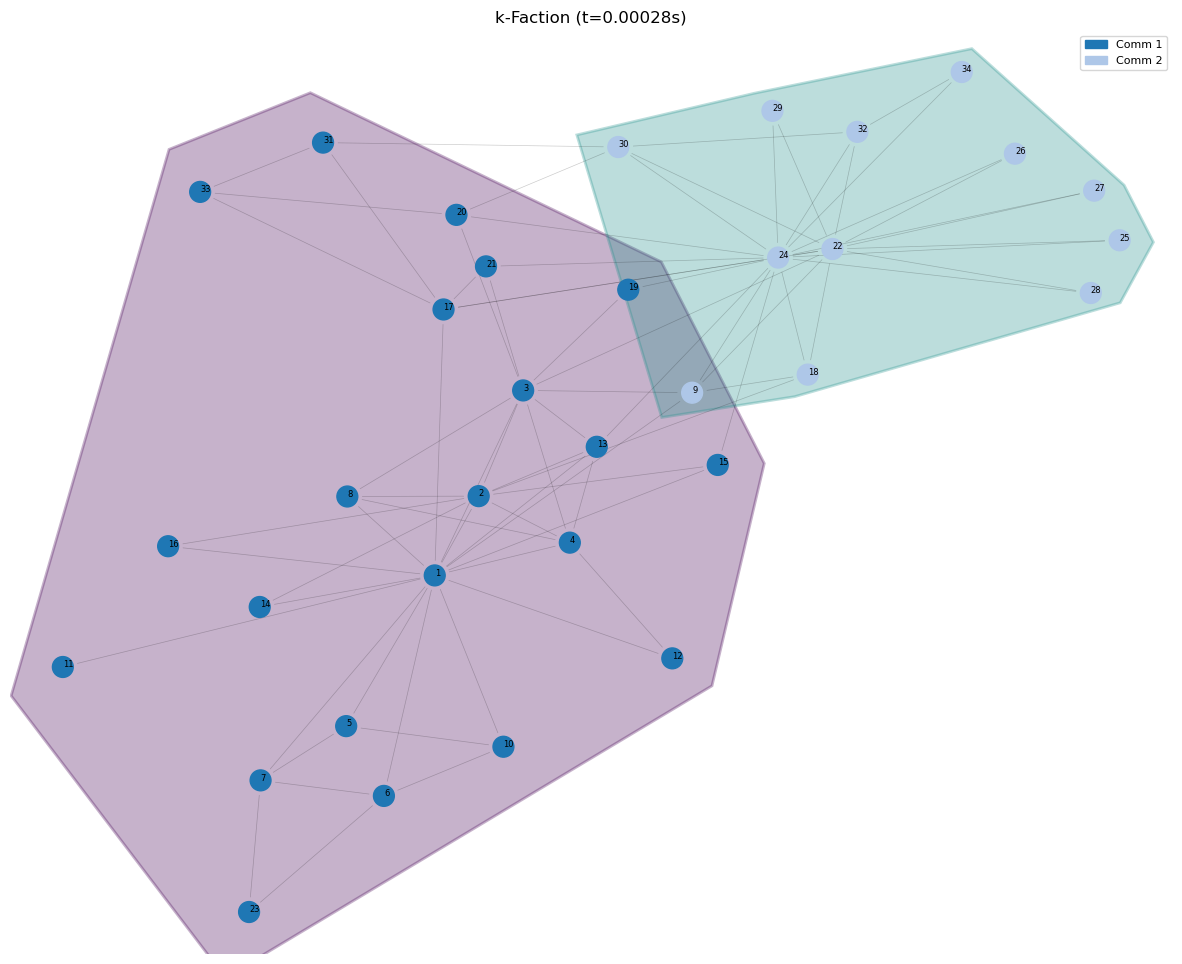

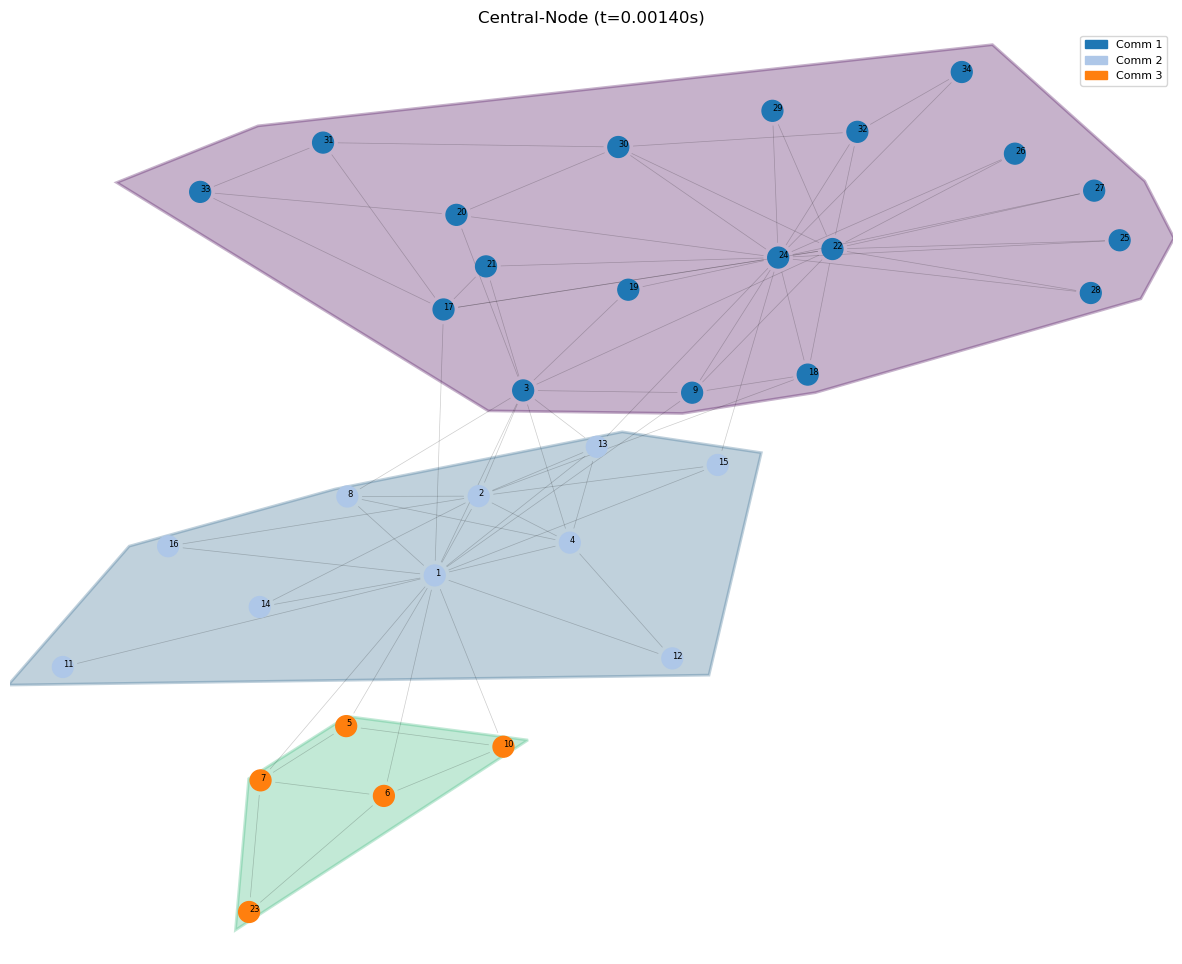

In [13]:
visualize_community(nx.karate_club_graph(), 'kf', seed=1)
visualize_community(nx.karate_club_graph(), 'cn', seed=1)

#### American Football Teams

A graph of U.S. college teams connected by games played, offering a more complex, mid-sized network with clear conference structures.

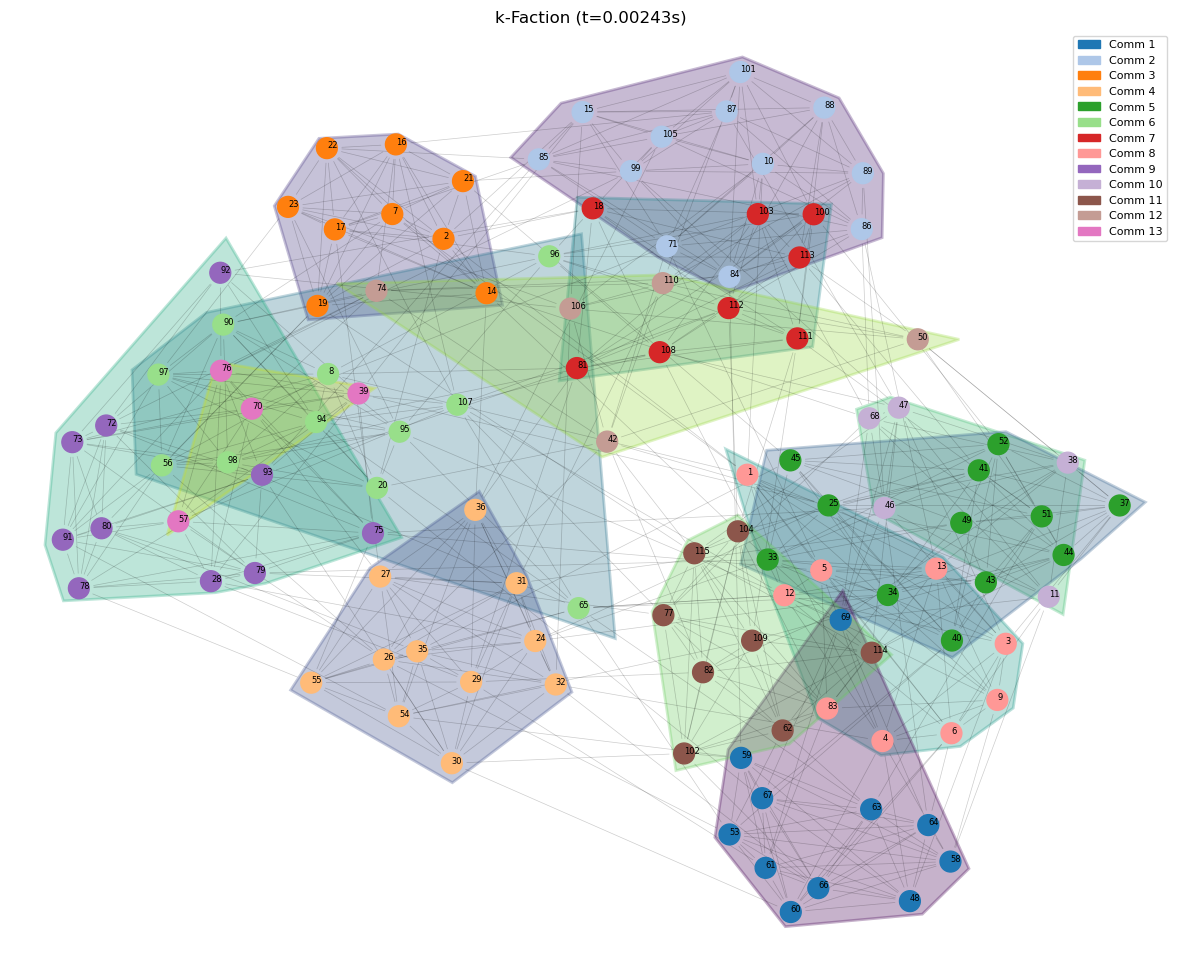

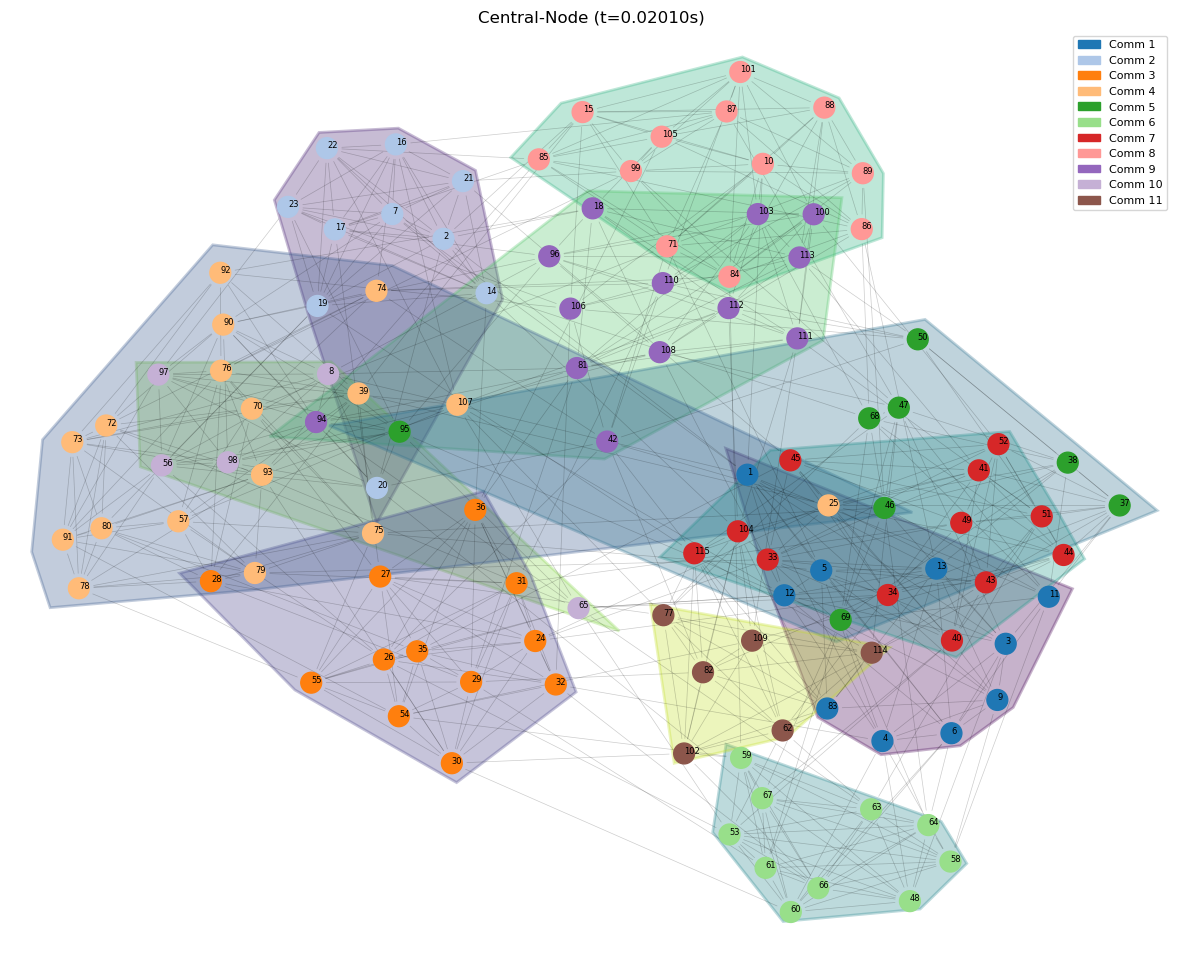

In [14]:
# Percorso al file GML nella cartella 'data'
american_football_graph = load_graph('Data/Football_Graph/football.gml')
visualize_community(american_football_graph, 'kf')
visualize_community(american_football_graph, 'cn')

#### Dolphin Social Network

n ecological network of Indo-Pacific bottlenose dolphins, where community membership reflects real social groupings in the wild.

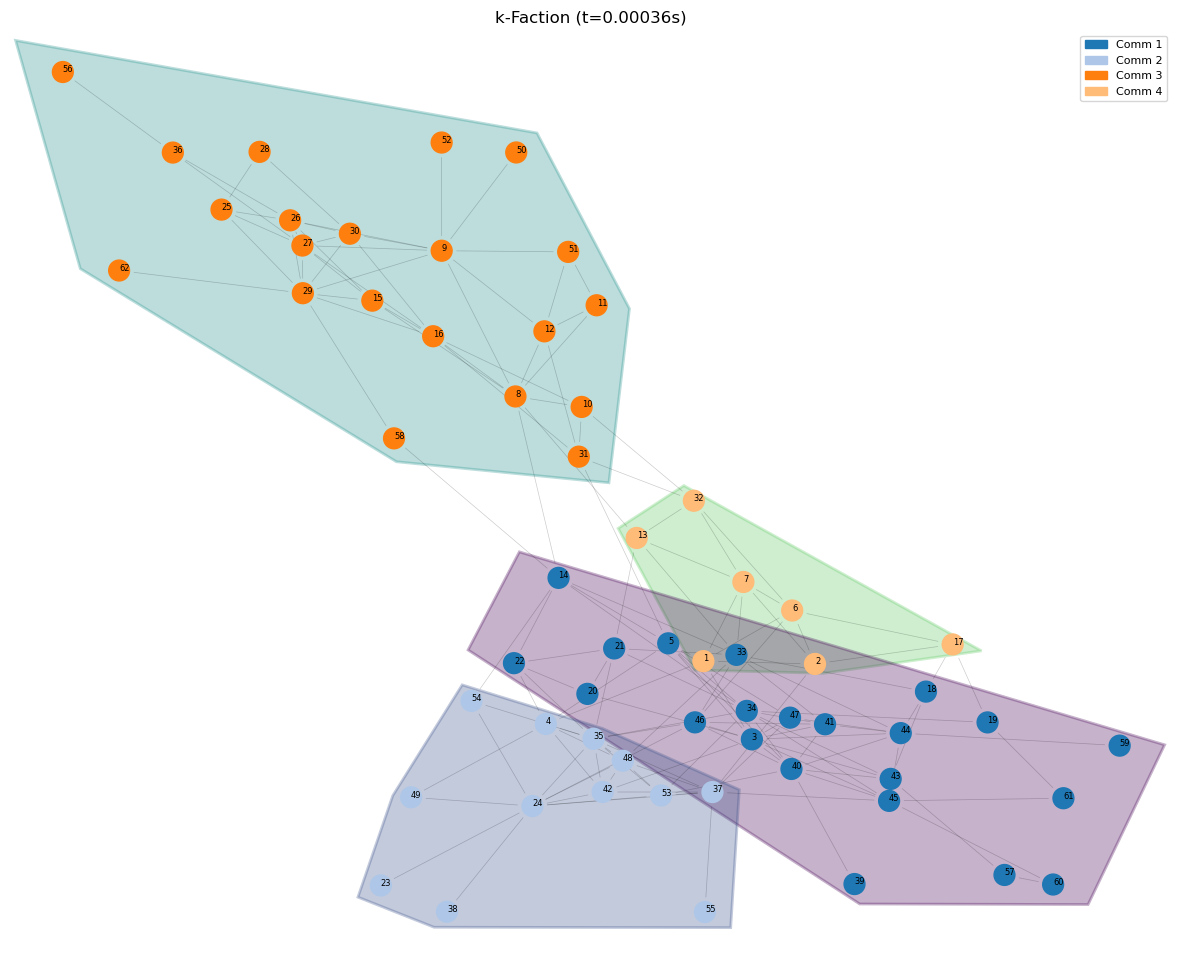

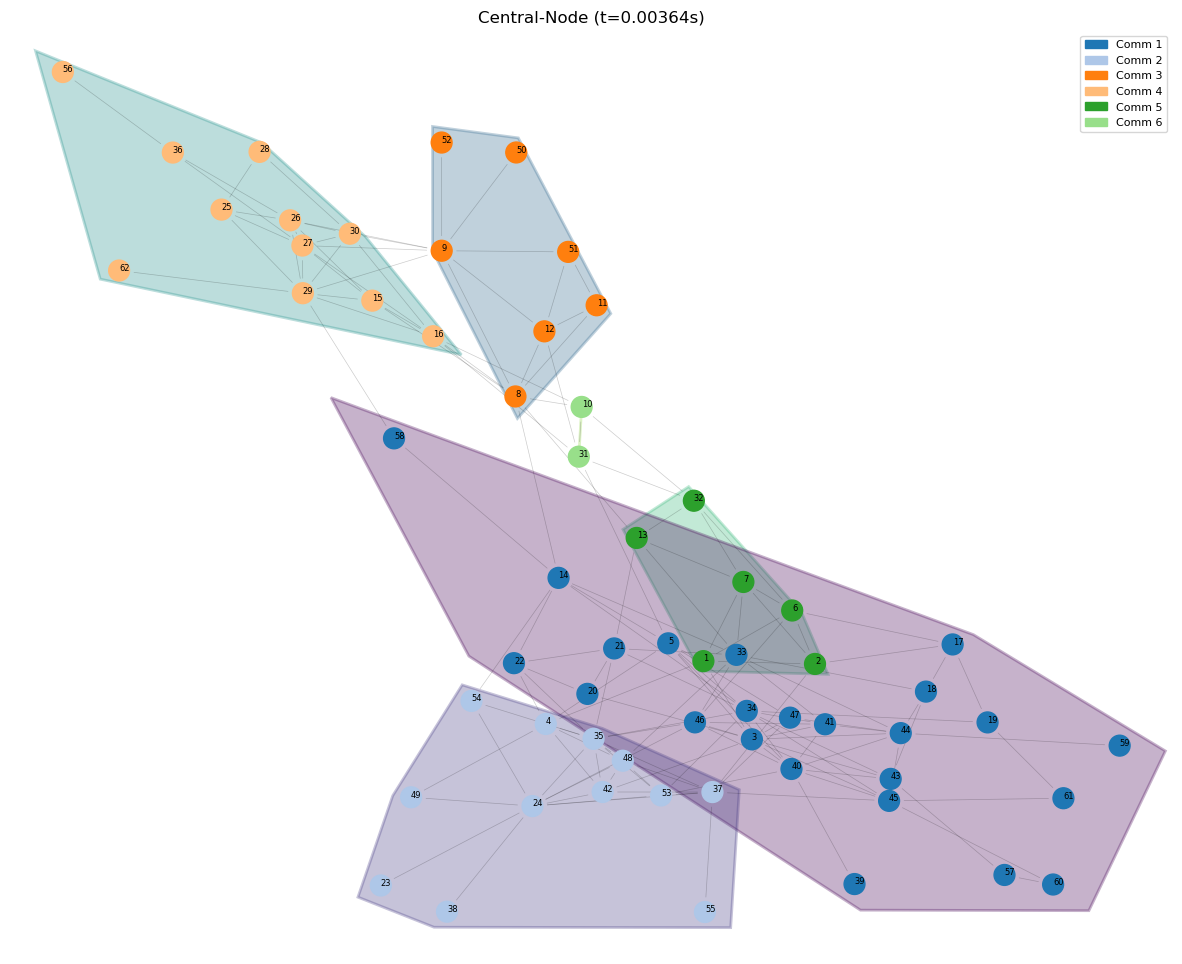

In [15]:
# Percorso al file GML nella cartella 'data'
dolphins_graph = load_graph('Data/Dolphin_Graph/dolphins.gml')
visualize_community(dolphins_graph, 'kf')
visualize_community(dolphins_graph, 'cn')

#### Preliminary Benchmarks Results

| Graph             | Avg Time (s) k-Faction | Avg Time (s) Central-Node |
|-------------------|------------------------|---------------------------|
| Karate Club       | 0.0002                 | 0.0120                    |
| American Football | 0.0038                 | 0.2900                    |
| Dolphins          | 0.0005                 | 0.0500                    |

The preliminary benchmarks clearly show that the k-Faction algorithm is dramatically faster often by two orders of magnitude than the Central-Node method, thanks to its reliance on maximal clique enumeration and relatively few merge steps. However, these measurements were obtained on tiny graphs (Karate Club, American Football, Dolphins) on a PC equipped with a Ryzen 7700X processor and therefore lack statistical significance. In later experiments, we will evaluate both algorithms on a much larger and more realistic graph such as the MovieLens 100K dataset—to gain a true understanding of their performance and community-detection quality at scale.


### Constructing the user-user network

Build a bipartite User–Artist graph from the listening data, then project it onto the user side with edge weights = #common artists. The projection is the starting point for community detection.

In [16]:
def build_user_item_bipartite(ratings):
    B = nx.Graph()
    for _, row in ratings.iterrows():
        user = f'u{row["user_id"]}'
        item = f'i{row["item_id"]}'
        B.add_node(user, bipartite=0)
        B.add_node(item, bipartite=1)
        B.add_edge(user, item)
    return B

def project_user_graph(B):
    users_list = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
    return bipartite.weighted_projected_graph(B, users_list)


B = build_user_item_bipartite(ratings)
G_user = project_user_graph(B)
print(nx.number_of_nodes(G_user), "users in projection")

943 users in projection


Retain only strong links (users who share ≥ `min_common` artists), following the rough-selection idea that speeds up the CFCD algorithm by working on a denser but *relevant* sub-graph.


In [17]:
def filter_user_graph(G_user, min_common=5):
    G_filtered = nx.Graph()

    # Add strong edges (based on co-rated items)
    for u, v, data in G_user.edges(data=True):
        if data['weight'] >= min_common:
            G_filtered.add_edge(u, v, weight=data['weight'])

    # Re-add all user nodes (even if isolated)
    #G_filtered.add_nodes_from(G_user.nodes(data=True))  # keep attributes if any

    return G_filtered

G_filtered = filter_user_graph(G_user, min_common=20)
print(f"Projected user-user graph has {G_filtered.number_of_nodes()} nodes and {G_filtered.number_of_edges()} edges.")

Projected user-user graph has 908 nodes and 123565 edges.


## User network based on user tag attributes

The next block creates a demographic-based user network. First, the helper functions score how similar two users are:

- Demographic_similarity: weighted average of age closeness, gender match, and occupation match.
- Build_weighted_user_graph: adds every user as a node, then links any pair whose similarity is ≥ 0.7, storing the score as edge weight.

Finally, we define the trait weights (age 40 %, gender 30 %, occupation 30 %), build the graph, and print its size ready for community detection.

In [19]:
def demographic_similarity(u1, u2, weights):
    # Age: closer ages ↗ similarity (drops to 0 if 50-year gap)
    age_sim = max(0, 1 - abs(u1.age - u2.age) / 50)
    # Gender: 1 if same, else 0
    gender_sim = 1 if u1.gender == u2.gender else 0
    # Job: 1 if same occupation, else 0
    occupation_sim = 1 if u1.occupation == u2.occupation else 0

    # Weighted average of the three scores
    return (weights['age'] * age_sim +
            weights['gender'] * gender_sim +
            weights['occupation'] * occupation_sim)


def build_weighted_user_graph(users, weights, threshold=0.5):
    G = nx.Graph()                          # empty graph

    # add a node for each user, store their traits as attributes
    for _, row in users.iterrows():
        G.add_node(row.user_id,
                   age=row.age, gender=row.gender,
                   occupation=row.occupation)

    # connect user pairs whose demographic similarity ≥ threshold
    for i, u1 in users.iterrows():
        for j, u2 in users.iterrows():
            if i >= j:                       # skip repeats / self-pairs
                continue
            sim = demographic_similarity(u1, u2, weights)
            if sim >= threshold:
                G.add_edge(u1.user_id, u2.user_id, weight=sim)
    return G

# Set how much each trait counts in the similarity score
weights = {
    'age': 0.4,       # age difference matters 40 %
    'gender': 0.3,    # gender match counts 30 %
    'occupation': 0.3 # same job counts 30 %
}

# Build a user-to-user graph: connect two users if their
# demographic similarity (using the weights above) is ≥ 0.7
G_weighted = build_weighted_user_graph(users, weights, threshold=0.7)

# How big is the resulting network?
print(f"Weighted user graph: {G_weighted.number_of_nodes()} nodes, {G_weighted.number_of_edges()} edges")

Weighted user graph: 943 nodes, 30982 edges


After creating the demographic graph the `k-Faction` algorithm is executed, seeding with cliques ≥ 20 users and merging communities when overlap or inter-connectivity is at least 0.5. It then prints every community’s size and members plus the overall count of user-memberships.

In [20]:
k_communities = k_faction_community_detection(G_weighted, k=20, T=0.5, CONN=0.5)
print(f"Detected {len(k_communities)} communities")

sum_c = 0
for i, comm in enumerate(k_communities, 1):
    sum_c += len(comm)
    print("Community of size", len(comm))
    print(f"Community {i}: {sorted(comm)}")

sum_c

Detected 28 communities
Community of size 44
Community 1: [1, 4, 31, 39, 69, 73, 75, 105, 106, 132, 179, 234, 268, 293, 301, 308, 318, 349, 369, 414, 431, 435, 456, 470, 472, 480, 481, 517, 564, 567, 573, 627, 641, 644, 651, 717, 752, 832, 860, 867, 889, 900, 926, 936]
Community of size 31
Community 2: [1, 4, 44, 77, 143, 197, 211, 244, 294, 311, 325, 339, 441, 443, 456, 458, 488, 545, 670, 690, 715, 717, 718, 738, 739, 753, 790, 812, 832, 850, 889]
Community of size 59
Community 3: [2, 5, 11, 12, 18, 20, 38, 46, 120, 126, 128, 129, 149, 155, 165, 169, 236, 256, 273, 292, 316, 342, 352, 362, 373, 376, 389, 417, 418, 424, 437, 460, 505, 544, 602, 613, 617, 629, 681, 698, 713, 719, 721, 732, 733, 734, 751, 760, 797, 805, 809, 810, 835, 856, 859, 885, 907, 914, 930]
Community of size 26
Community 4: [3, 21, 22, 28, 50, 196, 199, 201, 293, 370, 385, 392, 445, 464, 498, 548, 695, 741, 745, 772, 801, 829, 833, 842, 853, 896]
Community of size 22
Community 5: [3, 33, 37, 66, 135, 255, 267, 30

1222

To compare the two algorithms, the communities generated by the `Central Node` are also

In [22]:
cn_communities = central_node_overlapping_communities(G_weighted)
print(f"Detected {len(cn_communities)} communities")

sum_c = 0
for i, comm in enumerate(cn_communities, 1):
    sum_c += len(comm)
    print("Community of size", len(comm))
    print(f"Community {i}: {sorted(comm)}")

sum_c

Detected 68 communities
Community of size 27
Community 1: [17, 42, 77, 112, 125, 190, 199, 220, 402, 440, 447, 475, 479, 526, 637, 664, 670, 676, 737, 774, 776, 783, 795, 814, 869, 877, 897]
Community of size 48
Community 2: [1, 4, 31, 44, 69, 73, 75, 77, 105, 132, 143, 197, 244, 268, 293, 294, 301, 311, 325, 369, 414, 431, 435, 441, 456, 458, 470, 472, 488, 517, 545, 567, 627, 641, 670, 715, 717, 718, 721, 738, 739, 790, 812, 832, 850, 867, 889, 936]
Community of size 30
Community 3: [22, 56, 153, 154, 156, 162, 248, 249, 285, 307, 353, 355, 394, 399, 412, 551, 584, 595, 622, 665, 689, 697, 727, 741, 746, 800, 862, 865, 893, 919]
Community of size 25
Community 4: [21, 44, 53, 78, 86, 94, 103, 178, 181, 187, 265, 357, 422, 498, 570, 587, 660, 663, 695, 703, 714, 723, 757, 771, 834]
Community of size 30
Community 5: [51, 126, 176, 226, 244, 247, 251, 261, 283, 428, 468, 476, 500, 520, 540, 606, 661, 684, 698, 748, 750, 770, 818, 826, 828, 896, 903, 910, 930, 933]
Community of size 26
Co

1772

The `k-Faction` algorithm proved to `run substantially faster` than the `Central-Node` method on our weighted user graph.

## Step 3: Community‑Based Collaborative Filtering

This cell defines and calls a function that finds the top-k users most similar to a given “target” user by blending two cosine similarities: one based on mean-centered rating behavior and one based on raw category (genre) preferences. It pulls user 300’s rating and genre vectors, computes each user’s mean rating to center the data, calculates a ratings-based and a categories-based similarity array, zeroes out the target’s self-similarity, merges them with weight λ, then sorts and returns the k highest scores and their user indices—so x holds the neighbor IDs and z their combined similarity values.

Formula:    `sim(i,j) = (1-λ)·sim_R + λ·sim_cat`

- `sim_R`   = corrected cosine similarity on centred ratings
- `sim_cat` = cosine similarity on the binary tag matrix



In [23]:
def compute_combined_similarity_to_user(user_item_matrix, user_category_matrix, target_user, k=10, lambda_=0.5):
    # 1. Extract the target user's raw rating vector and category (genre/tag) vector
    target_rating_vector   = user_item_matrix.loc[target_user].values.reshape(1, -1)
    target_category_vector = user_category_matrix.loc[target_user].values.reshape(1, -1)

    # 2. Compute each user's mean rating (ignoring zeros as “no rating”)
    user_means = user_item_matrix.replace(0, np.nan).mean(axis=1)

    # 3. Center all users’ rating vectors by subtracting their mean
    centered_user_item_matrix = user_item_matrix.sub(user_means, axis=0).fillna(0)
    centered_target_vector    = target_rating_vector - user_means[target_user]

     # 4. Compute two similarity arrays:
    sim_r  = cosine_similarity(centered_target_vector, centered_user_item_matrix.values)[0]
    sim_cat = cosine_similarity(target_category_vector, user_category_matrix.values)[0]

    # 5. Zero out self-similarity so the user isn’t their own neighbour
    if target_user in user_item_matrix.index:
        idx = user_item_matrix.index.get_loc(target_user)
        sim_r[idx]   = 0
        sim_cat[idx] = 0

    # 6. Blend the two similarity measures via λ:
    combined = (1 - lambda_) * sim_r + lambda_ * sim_cat

    # 7. Identify the top-k most similar users (highest combined scores)
    top_k_users = np.argsort(combined)[-k:][::-1]

    # 8. Return their indices and the corresponding similarity values
    return top_k_users, combined[top_k_users]

# Example invocation for user ID 300:
x, z = compute_combined_similarity_to_user(
    rating_matrix_filled,
    binary_user_genre_matrix,
    target_user=300
)

The following cell defines a predict_rating function that, for a given user and item, first gathers all users in any shared community as candidate neighbours; if none exist it falls back to the user’s own non-zero average. It then filters those neighbours to only those who have rated the target item, adds the target user back in if needed, and computes combined similarities (rating-based + category-based) to pick the top-k neighbours. Finally it predicts the rating as the user’s mean plus a weighted sum of those neighbours’ mean-centered ratings.

In [34]:
def predict_rating(user_id, item_id, communities, rating_matrix, item_category_matrix, k=10, lambda_=0.5, round_val=3, verbose=False):
    # 1. Collect all users in any community that contains the target user
    candidate_neighbours = set()
    for community in communities:
        if user_id in community:
            candidate_neighbours.update(community)

    # 2. If no neighbours found, fall back to this user’s own average rating
    if not candidate_neighbours:
        user_ratings = rating_matrix.loc[user_id]
        rated = user_ratings != 0
        return user_ratings[rated].mean() if rated.any() else 0

    candidate_neighbours = list(candidate_neighbours)

    # 3. Keep only neighbours who have rated the target item
    ratings_series = rating_matrix.loc[candidate_neighbours, item_id]
    similar_users = ratings_series[ratings_series != 0].index

    # 4. If still no ratings, we cannot predict
    if similar_users.empty:
        if verbose:
            print(f"Item {item_id} has no ratings from similar users.")
        return None

    # 5. Ensure the target user is included for similarity computation
    if user_id in similar_users:
        selected_users = list(similar_users)
    else:
        selected_users = list(similar_users) + [user_id]

    # 6. Extract the small user–item and user–category matrices for these users
    comm_user_item_matrix = rating_matrix.loc[selected_users]
    comm_item_cate_matrix = item_category_matrix.loc[selected_users]

    # 7. Compute combined similarities between the target user and each neighbour
    top_k_rel, similarities = compute_combined_similarity_to_user(
        comm_user_item_matrix,
        comm_item_cate_matrix,
        target_user=user_id,
        k=k,
        lambda_=lambda_
    )

    # 8. Map the indices returned by compute_combined_similarity_to_user back to user IDs
    comm_ids    = list(comm_user_item_matrix.index)
    top_k_users = [comm_ids[i] for i in top_k_rel]

    # 9. Gather the neighbours’ ratings for the target item
    ratings            = rating_matrix.loc[top_k_users, item_id]
    mean_user_ratings  = rating_matrix.loc[top_k_users].replace(0, np.nan).mean(axis=1)

    # 10. Compute each neighbour’s centered rating (r_vi - mean_rv)
    centered_ratings = ratings - mean_user_ratings

    # 11. Weighted sum of centered ratings, weights = absolute similarities
    weighted_sum = np.dot(centered_ratings, similarities)
    sum_weights  = np.sum(np.abs(similarities))

    # 12. If all similarities are zero, we can’t form a prediction
    if sum_weights == 0:
        return None

    # 13. Finally, add the weighted offset to the target’s own mean rating
    target_user_ratings = rating_matrix.loc[user_id]
    mean_target_rating  = target_user_ratings[target_user_ratings != 0].mean()

    predicted_rating = mean_target_rating + (weighted_sum / sum_weights)
    return round(predicted_rating, round_val)

# Example call: predict user 1’s rating for item 2 using k=30 neighbors
k_predict = predict_rating(1, 2, k_communities, rating_matrix_filled, binary_user_genre_matrix, k=30, lambda_=0.5)
cn_predict = predict_rating(1, 2, cn_communities, rating_matrix_filled, binary_user_genre_matrix, k=30, lambda_=0.5)

print(f"Predicted Rating for K-Faction: {k_predict}, Predicted Rating for Central Node: {cn_predict}")

Predicted Rating for K-Faction: 3.081, Predicted Rating for Central Node: 3.124


## Step 4: Train Framework

TODO Comment the following cells

In [39]:
splits = [(90,10), (80,20), (70,30)]

train_test_dicts = {}

for trn, tst in splits:

    # Apply train test split for all splits
    train_df, test_df = train_test_split(ratings, test_size=tst/100, random_state=RNG)

    print(f"Split: ({trn}, {tst}), Train set size: {train_df.shape}, Test set size: {test_df.shape}")

    # Insert Data into the Dictionary
    train_test_dicts[(trn, tst)] = {
        "train": train_df.reset_index(drop=True),
        "test": test_df.reset_index(drop=True),
        # 2.1 User-Item Rating Matrix (Train)
        "train_training_matrix": train_df.pivot(index="user_id", columns="item_id", values="rating").fillna(0),
        # 2.2 Binary User-Category Matrix (Train) — if you have user genres or attributes
        # (Assuming you have a function for this, e.g., `build_binary_user_genre_matrix`)
        "train_user_category_matrix": build_user_genre_matrix(train_df, items)
    }

Split: (90, 10), Train set size: (90000, 3), Test set size: (10000, 3)
Split: (80, 20), Train set size: (80000, 3), Test set size: (20000, 3)
Split: (70, 30), Train set size: (70000, 3), Test set size: (30000, 3)


In [ ]:
results = {}

In [ ]:
ks = [20, 30, 40, 50, 60, 70]
communities = {"Central_Node": cn_communities, "K_Faction": k_communities}

for k in ks:
    for alg_name, comm in communities.items():
        for split, data in train_test_dicts.items():

            if (alg_name, split, k) in results.keys():
                continue

            true_ratings = []
            predicted_ratings = []

            start = datetime.now()
            print(f"Predicting: {alg_name}, Split: {split}, k: {k}")

            for idx, row in data["test"].iterrows():
                user_id = row["user_id"]
                item_id = row["item_id"]
                true_rating = row["rating"]

                # Skip if user or item not in train
                if user_id not in data["train_training_matrix"].index or item_id not in data["train_training_matrix"].columns:
                    continue  # skip prediction for cold-start cases

                pred = predict_rating(
                    user_id,
                    item_id,
                    comm,
                    data["train_training_matrix"],
                    data["train_user_category_matrix"],
                    k=k,
                    lambda_=0.5,
                    verbose=False
                )

                if pred is not None:
                    true_ratings.append(true_rating)
                    predicted_ratings.append(pred)
            end = datetime.now()

            results[(alg_name, split, k)] = {"True": np.array(true_ratings), "Predicted": np.array(predicted_ratings), "Time": end - start}


In [81]:
threshold = 4.0
accuracy_results = {}

for key, result in results.items():

    # Mean Absolute Error
    mae = mean_absolute_error(result["True"], result["Predicted"])

    # Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(result["True"], result["Predicted"]))

    # Precision and Recall @ threshold (optional for recommender tasks)
    # If you want to calculate Precision/Recall, you need a threshold (e.g., recommend if rating >= 4)
  # You can adjust this
    predicted_positive = result["Predicted"] >= threshold
    true_positive = result["True"] >= threshold

    true_positives = np.sum(predicted_positive & true_positive)
    predicted_positives = np.sum(predicted_positive)
    actual_positives = np.sum(true_positive)

    precision = true_positives / predicted_positives if predicted_positives != 0 else 0
    recall = true_positives / actual_positives if actual_positives != 0 else 0

    accuracy_results[key] = {"MAE": mae, "RMSE": rmse, "Precision": precision, "Recall": recall}

In [82]:
accuracy_results

{('Central_Node', (90, 10), 30): {'MAE': 0.8020475425634437,
  'RMSE': 1.0226504279800284,
  'Precision': 0.7755102040816326,
  'Recall': 0.41007194244604317},
 ('Central_Node', (80, 20), 30): {'MAE': 0.8153927162695197,
  'RMSE': 1.0391543395189737,
  'Precision': 0.7855611150822016,
  'Recall': 0.4181091877496671},
 ('Central_Node', (70, 30), 30): {'MAE': 0.82215598601806,
  'RMSE': 1.0501665731410657,
  'Precision': 0.7723770005927683,
  'Recall': 0.41821799974322765},
 ('K_Faction', (90, 10), 30): {'MAE': 0.8004517728999578,
  'RMSE': 1.0199721909256712,
  'Precision': 0.7875980042765502,
  'Recall': 0.4125443345155871},
 ('K_Faction', (80, 20), 30): {'MAE': 0.810100702202362,
  'RMSE': 1.0331230837881733,
  'Precision': 0.7790143084260731,
  'Recall': 0.41338582677165353},
 ('K_Faction', (70, 30), 30): {'MAE': 0.8152420498495918,
  'RMSE': 1.0405840506942396,
  'Precision': 0.7758661324534527,
  'Recall': 0.4152633238725954},
 ('Central_Node', (90, 10), 40): {'MAE': 0.801780490416

In [84]:
# Convert to DataFrame
rows = []
for (alg, split, k), metrics in accuracy_results.items():
    rows.append({
        'algorithm': alg,
        'train_split': split[0],
        'test_split': split[1],
        'k': k,
        'MAE': metrics['MAE'],
        'RMSE': metrics['RMSE'],
        'Precision': metrics['Precision'],
        'Recall': metrics['Recall']
    })

df_results = pd.DataFrame(rows)

# Save to CSV
df_results.to_csv('accuracy_results.csv', index=False)

In [86]:
# Reload from CSV
df_loaded = pd.read_csv('accuracy_results.csv')

# Reconstruct the dictionary
accuracy_results = {}
for _, row in df_loaded.iterrows():
    key = (row['algorithm'], (int(row['train_split']), int(row['test_split'])), int(row['k']))
    accuracy_results[key] = {
        'MAE': row['MAE'],
        'RMSE': row['RMSE'],
        'Precision': row['Precision'],
        'Recall': row['Recall']
    }

# Step 5: Evaluate Results

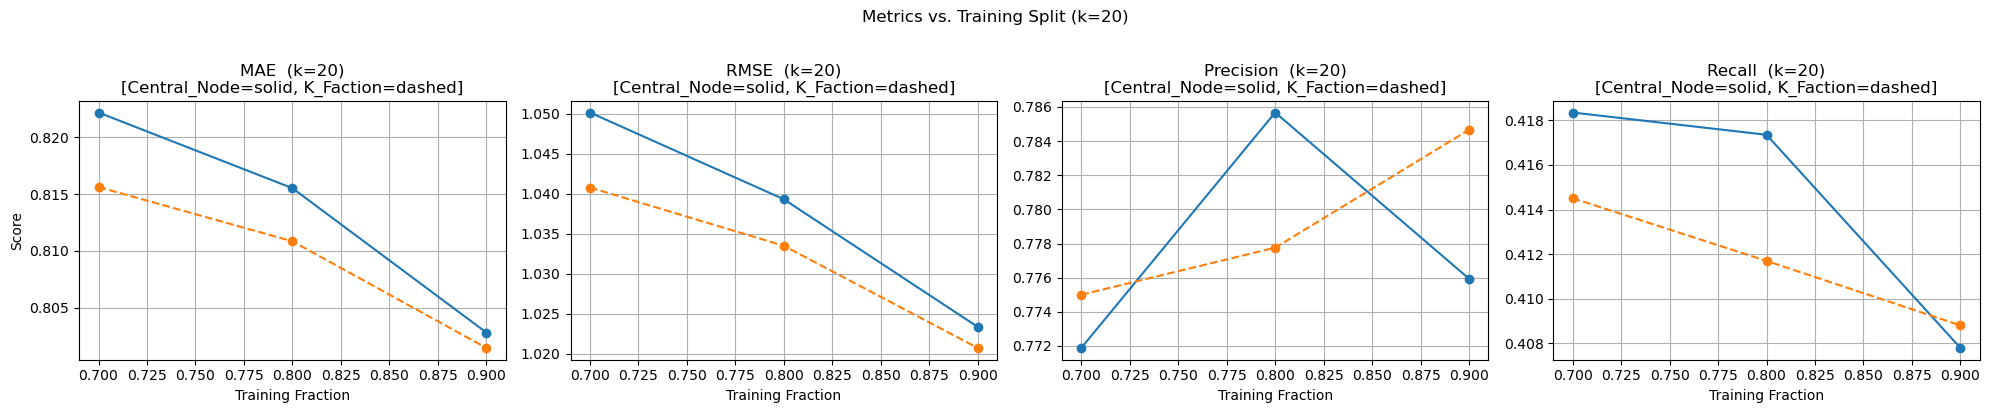

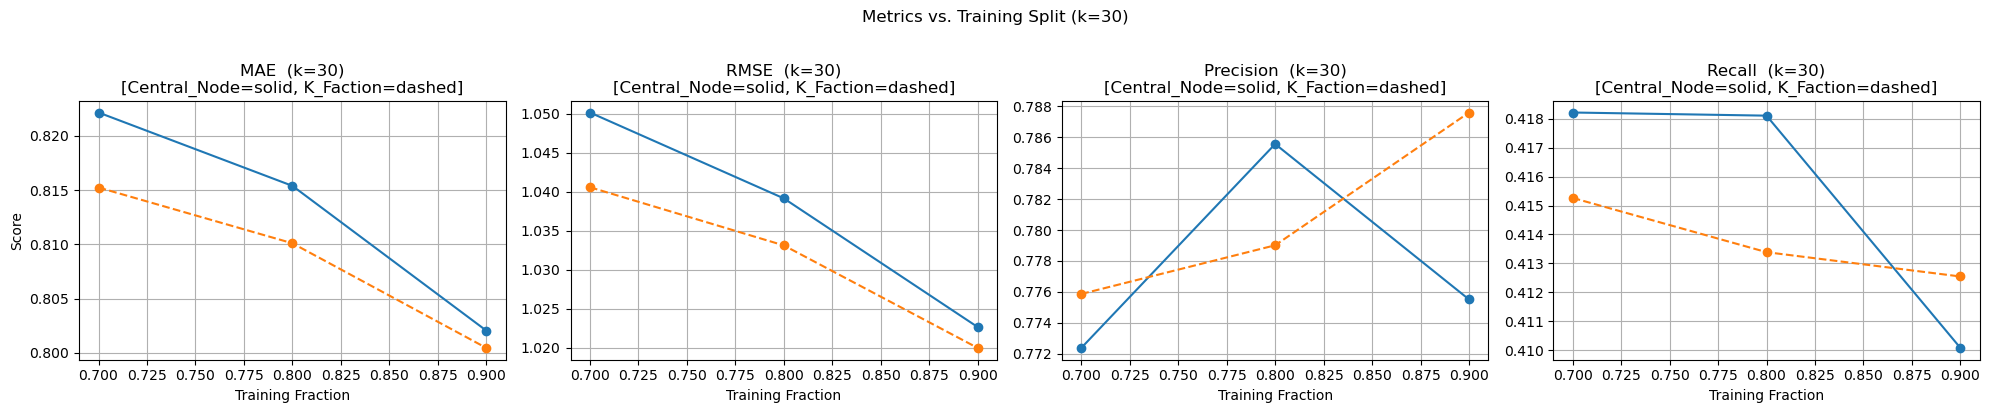

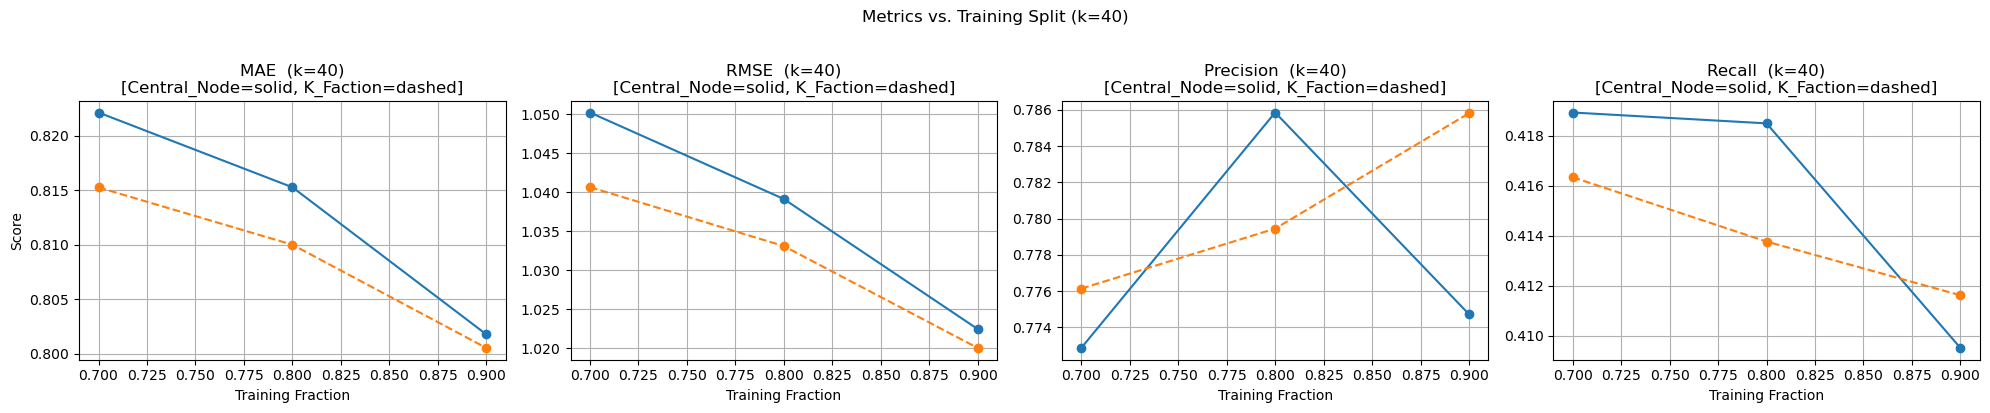

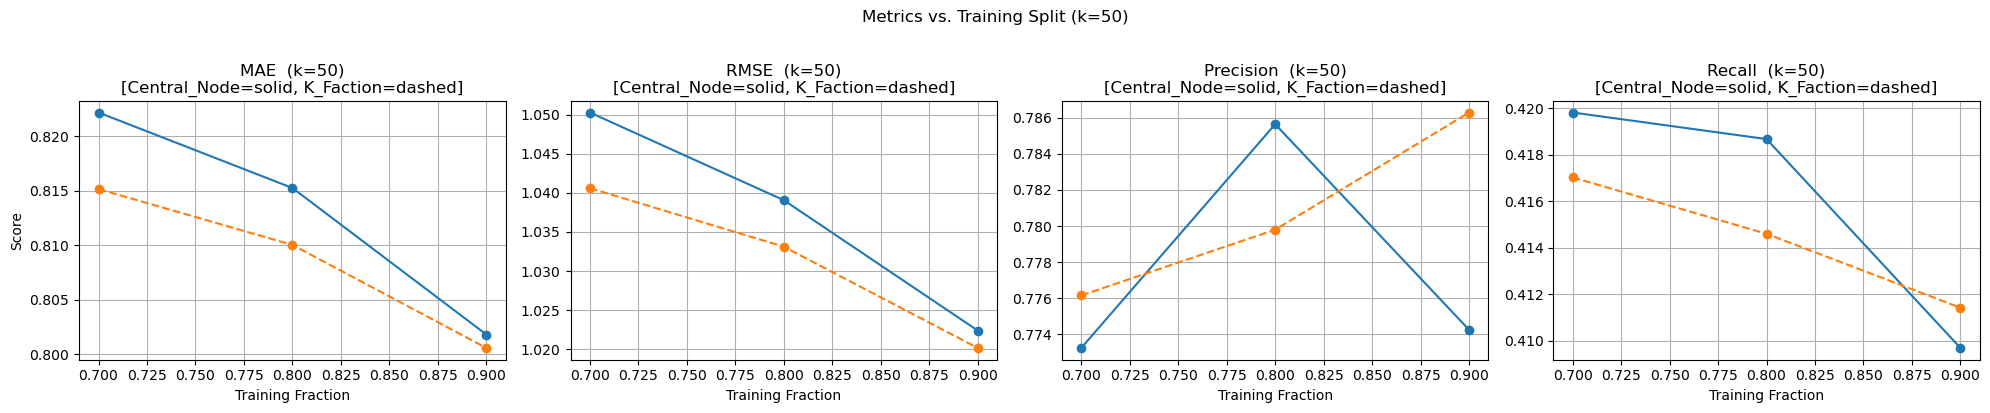

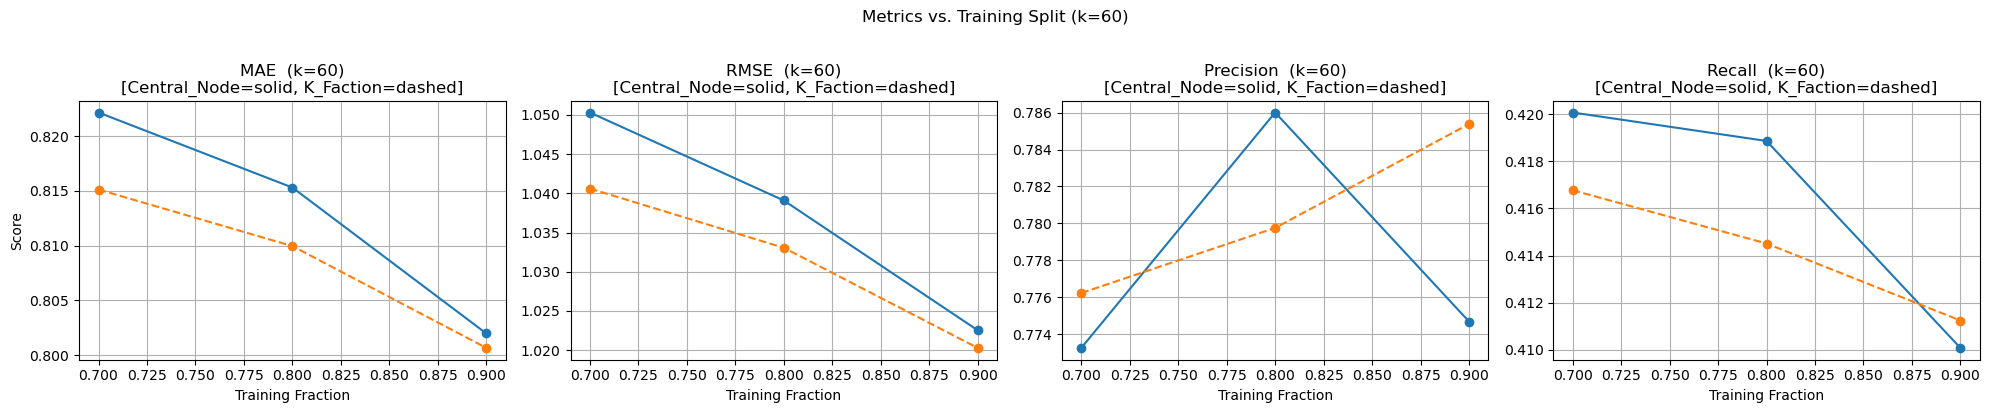

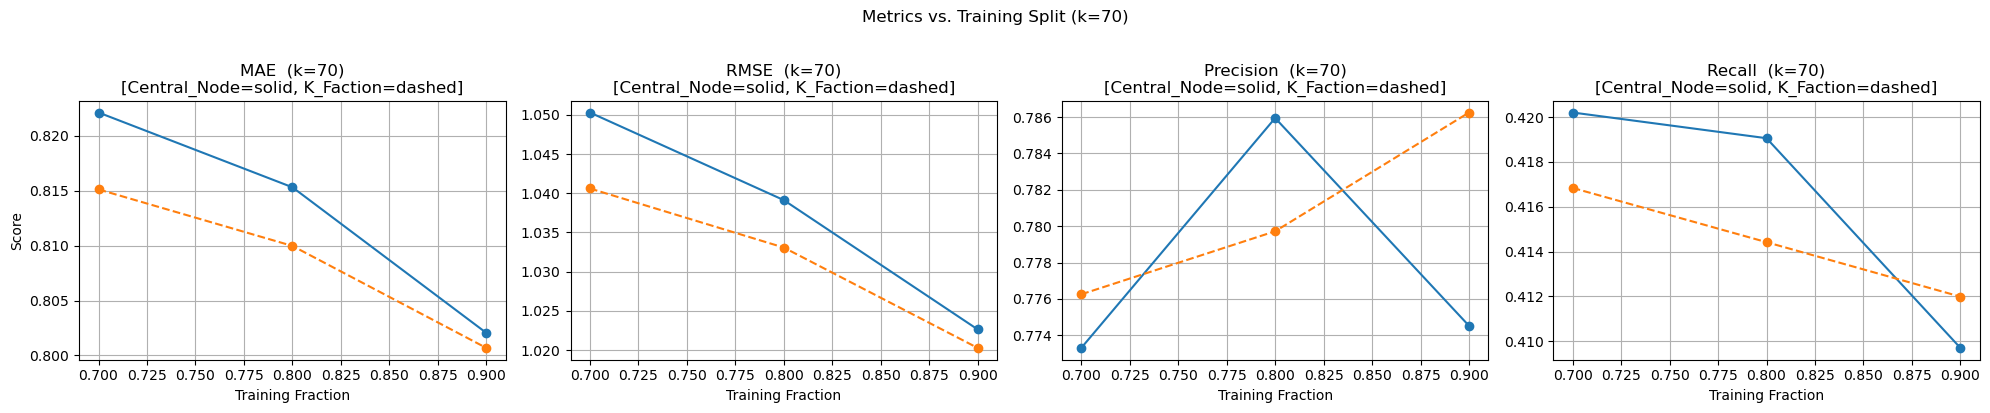

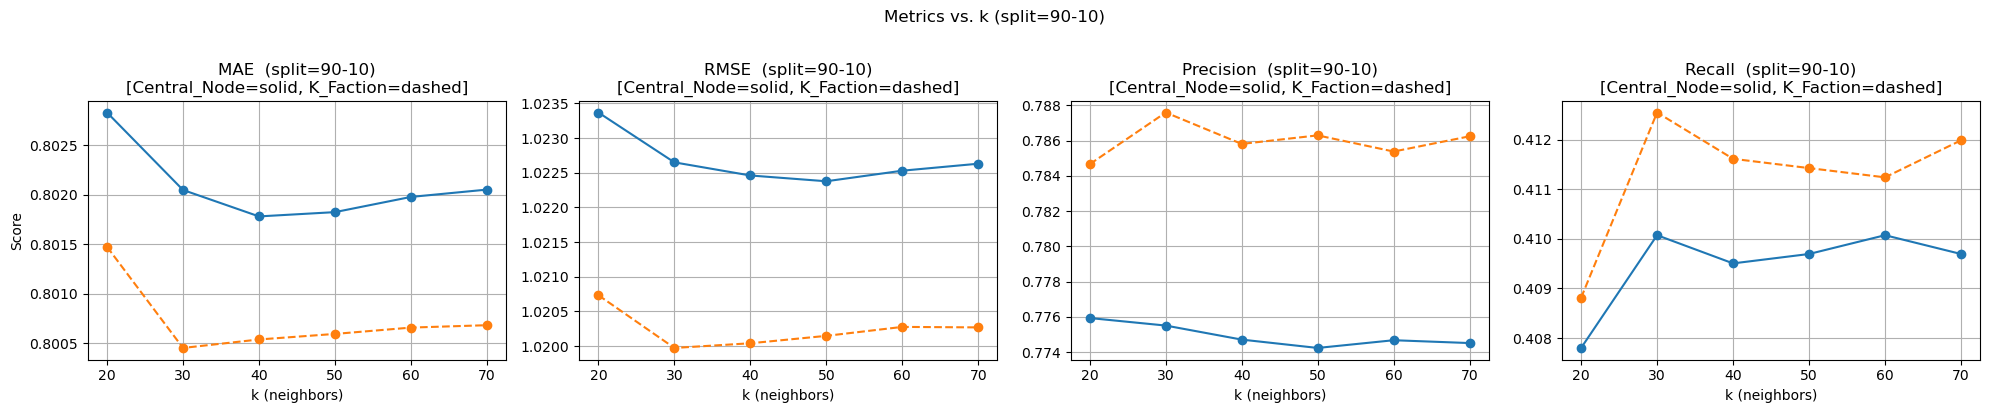

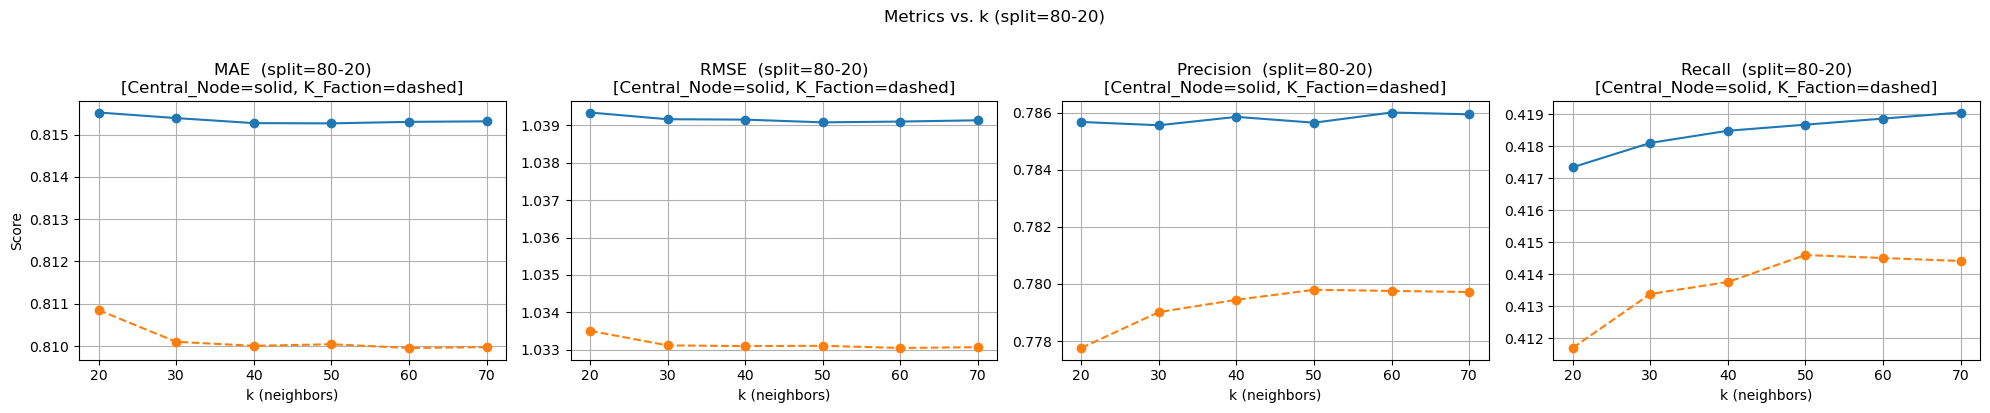

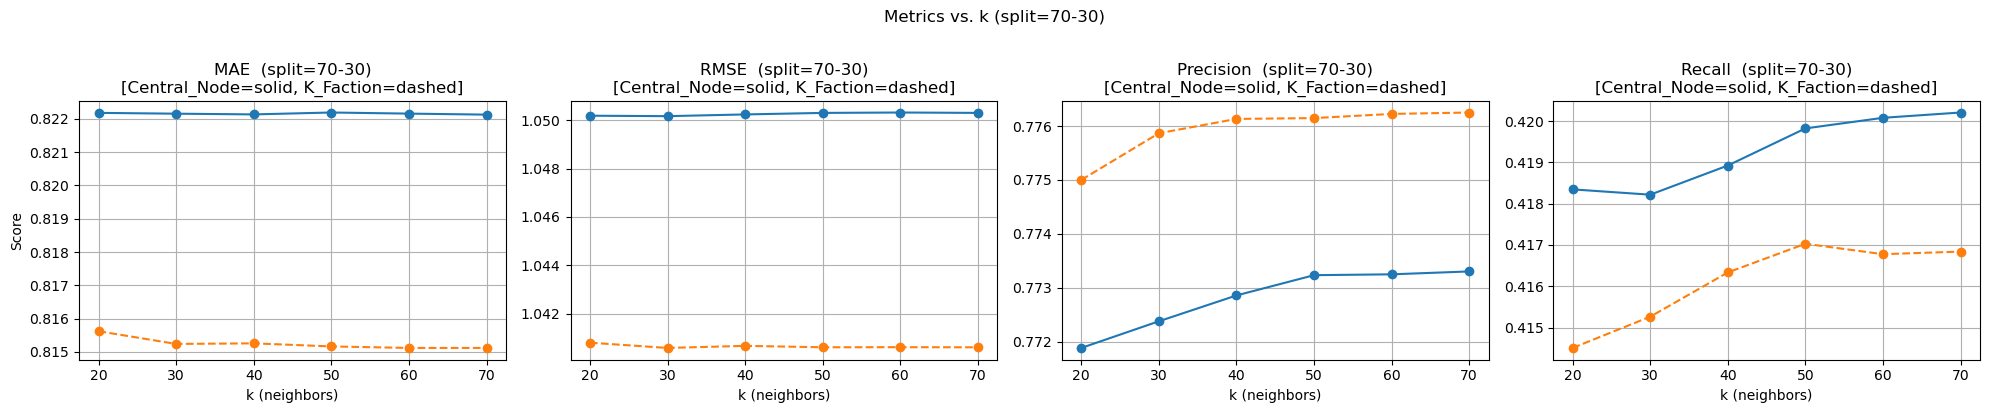

In [87]:
# fixed order & styles
algs   = ['Central_Node', 'K_Faction']
styles = {'Central_Node':'-', 'K_Faction':'--'}

def plot_all_metrics_vs_split(res, fixed_k, metrics):
    # 1) find all splits at this k
    splits = sorted(
        {split for (alg, split, k) in res if k == fixed_k},
        key=lambda s: s[0]/(s[0]+s[1])
    )
    # 2) convert to train‐fraction
    split_fracs = [s[0]/(s[0]+s[1]) for s in splits]

    # 3) make one row of len(metrics) plots
    fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 4), sharex=True)

    # 4) for each metric, plot both algs
    for ax, metric in zip(axes, metrics):
        for alg in algs:
            y = [
                res.get((alg, split, fixed_k), {}).get(metric, np.nan)
                for split in splits
            ]
            ax.plot(split_fracs, y,
                    linestyle=styles[alg],
                    marker='o')
        # embed line‐style legend in title
        line_info = ", ".join(
            f"{alg}={'solid' if styles[alg]=='-' else 'dashed'}"
            for alg in algs
        )
        ax.set_title(f"{metric}  (k={fixed_k})\n[{line_info}]")
        ax.set_xlabel("Training Fraction")
        ax.grid(True)

    axes[0].set_ylabel("Score")
    plt.suptitle(f"Metrics vs. Training Split (k={fixed_k})", y=1.02)
    plt.tight_layout()
    plt.show()


def plot_all_metrics_vs_k(res, fixed_split, metrics):
    # 1) find all k values at this split
    k_values = sorted({k for (alg, split, k) in res if split == fixed_split})

    # 2) one row of len(metrics) plots
    fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 4))

    # 3) plot each metric
    for ax, metric in zip(axes, metrics):
        for alg in algs:
            y = [
                res.get((alg, fixed_split, k), {}).get(metric, np.nan)
                for k in k_values
            ]
            ax.plot(k_values, y,
                    linestyle=styles[alg],
                    marker='o')
        line_info = ", ".join(
            f"{alg}={'solid' if styles[alg]=='-' else 'dashed'}"
            for alg in algs
        )
        ax.set_title(f"{metric}  (split={fixed_split[0]}-{fixed_split[1]})\n[{line_info}]")
        ax.set_xlabel("k (neighbors)")
        ax.grid(True)

    axes[0].set_ylabel("Score")
    plt.suptitle(f"Metrics vs. k (split={fixed_split[0]}-{fixed_split[1]})", y=1.02)
    plt.tight_layout()
    plt.show()

for k in ks:
    plot_all_metrics_vs_split(accuracy_results, fixed_k=k, metrics=["MAE", "RMSE", "Precision", "Recall"])

for split in splits:
    plot_all_metrics_vs_k(accuracy_results, fixed_split=split, metrics=["MAE", "RMSE", "Precision", "Recall"])